# Tennis

The code below "solves" the tennis environment, meaning it gets two agents to succesfully play the game. Or, in more technical terms, the average game reward is +0.5 for 100 games in a row.

This game is actually a toy example, where each agent only sees an observation space of 8 variables. The action space consists of two actions that control movement in the x and y axes. 

It takes 100 episodes to train, meaning that even taking into account the first episodes where it does fairly bad, in the end it is able to play much better than the required +0.5.

Regarding implementation, this is multi agent DDPG where the replay buffer can either be shared or separate per agent (configurable). Comparing it to the other projects, I dropped mlflow support (issues with artifact saving) and I added a configuration class which makes the other classes look cleaner.

In [1]:
# All the code is under src/ so add it to the path first
import sys
sys.path.insert(0, 'src/')

# graphics
import matplotlib.pyplot as plt
%matplotlib inline

# Imports
from unityagents import UnityEnvironment
from config import Config
import torch
import numpy as np

In [2]:
# Change according to your platform or where you have the tennis environment. See README for details.
env = UnityEnvironment(file_name='extras/Tennis.app')
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
env_info = env.reset(train_mode=True)[brain_name]

## Configuration

Set up the way agents will be trained and parameters for their networks. A better work could be done with some hyperparameter exploration and tracking (like I did in the other projects).

The configuration that worked for me:

- 2 hidden layers with 512 and 256 hidden units for both actor and critic
- Shared replay buffer
- Replay batch size 512
- Buffer size 1e6
- Replay without prioritization
- Update frequency (update_every) 4
- TAU = 1e-3
- Learning rate 1e-4 for actor and 3e-4 for critic
- Ornstein-Uhlenbeck noise (theta=0.15 and sigma=0.2)
- 20% dropout for critic

In [4]:
from memory import ReplayBuffer
from network import Actor, Critic
from noise import OUNoise

config = Config()

config.seed = 0
config.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
config.action_size = brain.vector_action_space_size
config.states = env_info.vector_observations
config.state_size = config.states.shape[1]
config.num_agents = len(env_info.agents)

config.actor_hidden_units = (512,256)
config.actor_learning_rate = 1e-4
config.actor_network = lambda: Actor(config.action_size, config.state_size, config.actor_hidden_units, config.seed).to(config.device)
config.actor_optimizer = lambda params: torch.optim.Adam(params, lr=config.actor_learning_rate)

config.critic_hidden_units = (512,256)
config.critic_learning_rate = 3e-4
config.weight_decay = 0
config.critic_network = lambda: Critic(config.action_size, config.state_size, config.critic_hidden_units, config.seed).to(config.device)
config.critic_optimizer = lambda params: torch.optim.Adam(params, lr=config.critic_learning_rate)

config.shared_replay_buffer = True
config.batch_size = 512
config.buffer_size = int(1e6)
config.discount = 0.99
config.update_every = 4
config.memory = lambda: ReplayBuffer(config.action_size, config.buffer_size, config.batch_size, config.seed, config.device)

config.noise = lambda: OUNoise(config.action_size, config.seed)

In [5]:
from multi_agent import MultiAgent
multi_agent = MultiAgent(config)

In [6]:
def ddpg(n_episodes=30000, max_t=2000):
    from collections import deque
    all_scores = []
    scores_window = deque(maxlen=100)
    
    for i_episode in range(1, n_episodes+1):
        
        multi_agent.reset()
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations           
        scores = np.zeros(config.num_agents)

        for i in range(max_t):
            actions = multi_agent.act(states)
            env_info = env.step(actions)[brain_name]
            rewards = env_info.rewards
            next_states = env_info.vector_observations
            dones = env_info.local_done

            multi_agent.step(states, actions, rewards, next_states, dones)

            scores += rewards
            states = next_states
        
        # If we took the maximum, it actually would be faster, this is more demanding
        # Even more demanding would be to take the minimum
        avg_score = np.mean(scores)
        scores_window.append(avg_score)
        all_scores.append(avg_score)
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        
        # The and is important, otherwise it exits before 100 episodes and it technally wouldn't be solved
        if np.mean(scores_window)>=0.5 and i_episode > 100:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-5, np.mean(scores_window)))
            torch.save(multi_agent.ddpg_agents[0].actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(multi_agent.ddpg_agents[0].critic_local.state_dict(), 'checkpoint_critic.pth')
            break 
            
    return all_scores

Episode 100	Average Score: 1.99
Episode 101	Average Score: 2.03
Environment solved in 96 episodes!	Average Score: 2.03


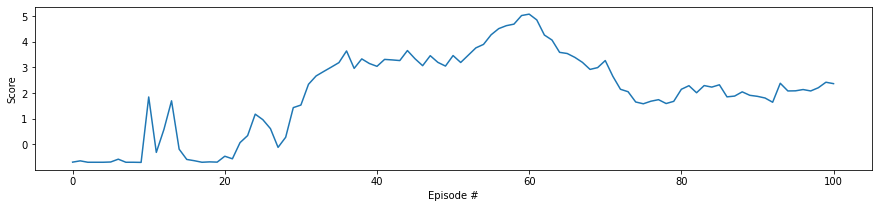

In [7]:
scores = ddpg()
# plot the scores
plt.figure(figsize=(15,3))
plt.plot(scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
env.close()

# Final thoughts

Even though this example is easy, it still amazes me to see how it looks like something "clicks" and it starts playing well around episode 30. But then it peaks at episode 60 and kind of forgets how to play. This loss of perromance is something that is happening to me in project 2 regarding continuous control (still not delivered!)

Even though it worked, technically more things could be done in order to make this more interesting for more difficult problems.

- Track experiments with mlflow (I did it in my first project, and in the second, which I still can't get to the average score of 30). I would be able to study hyperparameter combinations deeply, but it does make the code a bit harder to follow. It also offers the ability to see the graphic of performance while it is being trained instead of having to wait till the end.
- Make it possible to load configuration from a file, to improve (re)usability and experiment reproducibility

And on the reinforcement learning side:
- Prioritized replay. I never got to implement it, it is something that serves every learning algorithm.
- Metaparameter exploration for the agents and for the noise.
- Train agents completely independently, meaning having a separate memory buffers for each
- And the other way around too, have a shared network for the agents.
- Distinguish between training and not training by removing droput in the latter case (should play even better!)

